## Machine learning on EEG data

This tutorial walks through some basic tools for applying ML techniques on EEG data through MNE

### 1. Importing and preprocessing data

In [28]:
import mne

# Folder & files containing the data:
data_path = '/home/tyler/courses_pip2018ml/neuro_course/'
data_file = '817_1_PDDys_ODDBALL_Clean_curated'

filename = data_path + data_file

# We read the EEG epochs:
epochs = mne.read_epochs(filename + '.fif')

epochs = epochs['Standard', 'Novel']

#epochs.filter(l_freq = 0.1, h_freq = 20)
epochs.apply_baseline((None, 0))

This filename (/home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
Reading /home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif ...


<ipython-input-28-785d38bb3d86>:10: RuntimeWarning: This filename (/home/tyler/courses_pip2018ml/neuro_course/817_1_PDDys_ODDBALL_Clean_curated.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(filename + '.fif')


    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available
189 matching events found
No baseline correction applied
189 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Applying baseline correction (mode: mean)


<EpochsFIF  |   160 events (all good), -0.1 - 0.5 sec, baseline [None, 0], ~22.2 MB, data loaded,
 'Novel': 30
 'Standard': 130>

The main information we wish to retain is (a) the data (b) the true labels

In [29]:
# and get the data:
data = epochs._data

# and labels:
labels = epochs.events[:,-1]

##### Reminder exercise: how many trials of each condition do we have?

In [30]:
epochs.event_id

{'Standard': 201, 'Novel': 202}

### 2. Using sklearn to classify EEG data
We can now proceed with some mne.decoding and sklearn functionalities:

In [31]:
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import train_test_split

'make_pipeline' will create our analysis pipeline from a set of estimators, sklearn-style.
'Vectorizer' comes from MNE and will pull together all epochs x time x channels data to a vector of samples x channels
'StandardScaler' normalizes the data by their median

In [32]:
clf = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )

We can then use scikit-learn function 'train_test_split' to obtain a random split of training and test datasets:

In [33]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.4, random_state=0)

##### Exercise: What are the dimensions of the train / test datasets?

In [34]:
print(data.shape)
print(data_train.shape)
print(data_test.shape)

(160, 60, 301)
(96, 60, 301)
(64, 60, 301)


Now we can treat 'clf' as any sklearn estimator, and fit the training data to the classifier:

In [35]:
clf.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x7f645c8d65c0>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

And we can then use the classifier to predic the labels of the test data:

In [36]:
clf.predict(data_train)

array([202, 202, 201, 201, 202, 202, 201, 201, 201, 202, 201, 201, 201,
       201, 201, 201, 201, 202, 201, 201, 201, 201, 201, 201, 201, 201,
       202, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 202,
       201, 201, 201, 201, 201, 201, 202, 201, 201, 202, 202, 201, 201,
       201, 202, 201, 201, 201, 201, 201, 201, 202, 201, 201, 201, 201,
       201, 201, 202, 201, 202, 201, 201, 201, 201, 201, 201, 202, 201,
       201, 201, 201, 202, 202, 201, 201, 202, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201])

Or, we can directly compute the classification score:

In [37]:
clf.score(data_train,labels_train)

1.0

##### Exercise: What is the classification score on the test dataset? What do you observe?

In [38]:
clf.score(data_test,labels_test)

0.859375

Alternatively, we can also compute the classification accuracy based on cross-validation. By default, the selected model will be fitted on 3 different splits of the data:

In [39]:
clf_CV = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )

cross_val_score(clf_CV, data, labels)

array([0.90740741, 0.83018868, 0.83018868])

We can change the number of CV folds by including an additional parameter, 'cv':

Remember that for integer or None inputs, if the estimator is a classifier and the labels are binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used (i.e. the folds are made by preserving the percentage of samples for each class):

In [40]:
scores = cross_val_score(clf_CV, data, labels, cv=3)
print(scores)

[0.90740741 0.83018868 0.83018868]


And we can now compute the mean and 95% confidence interval of the classification accuracy:

In [41]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.07)


##### Exercise: What happens to the mean accuracy if you increase the CV folds? If you decrease them?

In [42]:
import matplotlib as plt

accuracy = []
cv_s = [3, 5, 7, 12]
for i in cv_s:
    scores = cross_val_score(clf_CV, data, labels, cv = i)
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    accuracy.append(scores.mean())

[0.90740741 0.83018868 0.83018868]
Accuracy: 0.86 (+/- 0.07)
[0.875   0.8125  0.875   0.8125  0.84375]
Accuracy: 0.84 (+/- 0.06)
[0.875      0.875      0.7826087  0.91304348 0.90909091 0.81818182
 0.86363636]
Accuracy: 0.86 (+/- 0.09)
[0.85714286 0.85714286 0.92857143 0.85714286 0.78571429 0.85714286
 0.92307692 0.92307692 0.84615385 0.92307692 0.75       1.        ]
Accuracy: 0.88 (+/- 0.13)


Additionally, we can evaluate multiple metrics for our models at once, like the time it takes to fit them, the train and test scores with the function 'cross_validate':

In [43]:
from sklearn.model_selection import cross_validate

cross_validate(clf, data, labels)

/home/tyler/anaconda3/envs/pip2018ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.59901094, 0.52811384, 0.56445122]),
 'score_time': array([0.1877563 , 0.1757257 , 0.18910956]),
 'test_score': array([0.90740741, 0.83018868, 0.83018868]),
 'train_score': array([1., 1., 1.])}

Now we will first apply PCA to our data and then classify them. What do you observe?

In [44]:
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA

pca = UnsupervisedSpatialFilter(PCA(0.75)) # we create an instance of PCA

In [45]:
pca_data = pca.fit_transform(data)

Now, we classify the PCA-transformed data:

In [46]:
cross_validate(clf, pca_data, labels)

/home/tyler/anaconda3/envs/pip2018ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.04494834, 0.04243445, 0.04296136]),
 'score_time': array([0.01252985, 0.01422215, 0.01228952]),
 'test_score': array([0.88888889, 0.81132075, 0.83018868]),
 'train_score': array([1., 1., 1.])}

What do you observe?

### 3. Optimizing our classifier

In the above paradigm we just used a default implementation of SVM with a linear kernel and a hyperparameter C set to 1. Now we will estimate the parameters of SVM through exhaustive Grid Search.

'GridSearchCV' exhaustively tests candidate models from a grid of parameter values specified in the following form:

In [53]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

Now we can use GridSearchCV directly in 'make_pipeline' to proceed with an optimized model:

In [55]:
clf_opt2 = make_pipeline(Vectorizer(), StandardScaler(), GridSearchCV(svm.SVC(), parameters,cv=5))
clf_opt2.fit(data, labels)
cross_val_score(clf_opt2,data,labels)

array([0.88888889, 0.83018868, 0.81132075])

What do you observe?

You can assess the optimized parameters through:

In [57]:
clf_opt2.steps[-1]

('gridsearchcv', GridSearchCV(cv=5, error_score='raise',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0))

The classifier that you trained & optimized above may still be biased. Any ideas why?

##### Exercise: how could you structure your dataset to make it unbiased?

In [58]:
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.5, random_state=0)
clf_opt2 = make_pipeline(Vectorizer(), StandardScaler(), GridSearchCV(svm.SVC(), parameters,cv=5))
clf_opt2.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x7efbc26fe978>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  de...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [63]:
import numpy as np
clf_opt2.steps[-1]

perf = cross_val_score(clf_opt2,data_test,labels_test, cv = 5)
np.mean(perf)

0.8004411764705882

### 4. Making a more sophisticated pipeline

In the steps above we were still evaluating a rather simplified version of our data, where we considered EEG data of one condition and the other irrespective of time. Now we will take the temporal dimension into account as well and will evaluate how classification accuracy changes across time.

For this we will use 'SlidingEstimator' from MNE:

In [65]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
clf_CV = make_pipeline(Vectorizer(), StandardScaler(),
                    svm.SVC(kernel='linear',C=1)
                   )
sl = SlidingEstimator(clf) # we apply the sliding estimator to 'clf'

CV_score_time = cross_val_multiscore(sl, data, labels)

What are the dimensions of the classification score now? Why?

In [66]:
CV_score_time.shape

(3, 301)

We can now plot the classification accuracy across time:

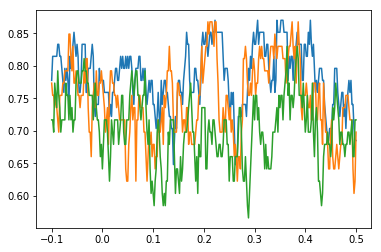

In [67]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()
ax.plot(epochs.times, CV_score_time.T)
plt.show()

##### Exercise: Can you now plot the mean classification accuracy over the CV folds as a function of time?

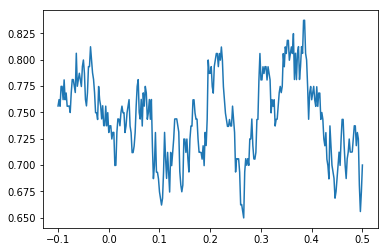

In [71]:
fig, ax = plt.subplots()
ax.plot(epochs.times, np.mean(CV_score_time, axis=0) )
plt.show()

Another important steps of classifying EEG data is to extract and visualize the features of our classifier. In the following case, we will extract the coefficients of SVM across time and plot them as topographic maps:

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-72-698a58050aee>:6: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  topo_ev.plot_joint(times=[.22, .3, .375, .45]);


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-72-698a58050aee>:6: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  topo_ev.plot_joint(times=[.22, .3, .375, .45]);


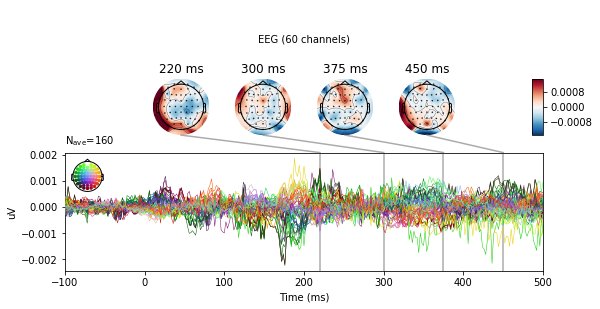

In [72]:
import numpy as np

topos = np.array([svm.SVC(kernel='linear').fit(time_point.T, labels).coef_ * time_point.std(1)
                  for time_point in data.T])[:, 0, :]
topo_ev = mne.EvokedArray(topos.T, info=epochs.info, tmin=-.1, nave=len(labels))
topo_ev.plot_joint(times=[.22, .3, .375, .45]);

##### Exercise: Can you now plot the classification coefficients on the time-points of maximal classification accuracy?

### 5. Implementing a more sophisticated pipeline

In the same pipeline we can additionally integrate dimensionality reduction techniques. How?